In [1]:
# Import Basic Python Functionality
import numpy as np
import pandas as pd
import random
import datetime
import time
import sys
import re
import os
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import matplotlib.dates as mdates
from IPython.display import Image
import string



#Import Python Libraries for Machine Learning
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score, calinski_harabaz_score, v_measure_score
from sklearn.preprocessing import MinMaxScaler, normalize, LabelBinarizer, minmax_scale
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import pairwise_distances, pairwise_distances_argmin_min


# Import Keras/Tensorflow Libraries for Deep Learning
import tensorflow as tf
import keras.backend as K
from keras.layers import Conv1D, SpatialDropout1D, Flatten, Activation, Lambda, Convolution1D, Dense
from keras.models import Input, Model, load_model, Sequential, save_model
from keras.utils import np_utils
import keras.layers
from keras import optimizers

class ScalarFormatterForceFormat(ScalarFormatter):
    def _set_format(self, vmin, vmax):  # Override function that finds format to use.
        self.format = "%0.0f"  # Give format here

tsne = TSNE()
xfmt = ScalarFormatterForceFormat()
xfmt.set_powerlimits((0,0))
xfmt.set_useMathText(True)
myFmt = mdates.DateFormatter('%H:%M')
pd.set_option('display.max_columns', None)
%matplotlib inline

Using TensorFlow backend.




# FaultNet: A Deep-Learning Framework for Unsupervised Time-Series Analysis and Anomaly Detection

Every day, vast amounts of unlabeled time-series data are collected across the globe, particularly status of health (SOH) data for equipment system monitoring and predictive maintenance. Unfortuantely, because this data is unlabeled, traditional supervised machine learning techniques are inapplicable, and unsupervised techniques, such as clustering, are demanded. Time-series clustering is an important and growing field, but there are many inherent challenges, such as missing data and complex time dependancies. In this work, we explore the unique challenges of time-series clustering, and present FaultNet, a data-driven framework for the rapid analysis and classification of unlabeled time-series data.

### _Task_:
Our task is two-fold:

1) Implement the Siamese-shift Encoder, a neural-network embedding function for transforming unlabeled time-series data onto a low-dimensional embedding space, where the embeddings are robust to temporal shifts and gaps, but sensitive to all other temporal anomalies.

2) Implement FaultNet, a framework for the rapid analysis of the time-series data, based on shift-encoded embeddings. FaultNet includes tools for both manual visual exploration, and automated anomaly detection.


### _Dataset_:
To train and test the network, we make use of a common time-series SOH streams: Battery Voltage. The data used comes from a Status of Health Server, which contains just over 2 years of data across 148 seperate equipment sites. These sites all operate at a nominal battery voltage of either 12 or 24V. Additionally, the power is supplied to the batteries by either Commercial Power or Solar Power.

### _Overview_:

In the remainder of this notebook, we will proceed as follows:

* STEP 1: EXPLORE THE DATASET

* STEP 2: DEFINE AND TRAIN THE ENCODER

* STEP 3: ANALYZE THE ENCODINGS

---

## STEP 1: EXPLORE THE DATASET
---

The dataset is formatted as a csv file. The Rows contain timestamped Radio Voltage values, and each column represents a seperate equipment location. The data has many missing values. To begin, we load the csv as a dataframe and build a plotting function to visually examine the data.

In [2]:
Volt_df = pd.read_csv('data/Radio_Voltage.csv')
Volt_df['TIME'] = pd.to_datetime(Volt_df['TIME'])
Volt_df['DATE'] = Volt_df.TIME.dt.date


We next perform some data wrangling to deal with missing values

In [3]:
for col in Volt_df.columns[1:-1]:
    Volt_df[col].values[Volt_df[col].values < 10] = np.nan

Volt_df = Volt_df.fillna(method='pad', limit=100)

/home/dickey/anaconda3/envs/Seis/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


### Visual Exploration of Battery Voltage at a Solar Power Site (AN)

To begin, we pick a single equipment site, in this case AN06, which operates on a 24V battery bank and is supplied by solar power. The full 120 weeks of SOH Voltage Data are plotted, and investigated visually, looking for any distinctive voltage profiles that are common throughout.

In [4]:
def plot_SOH(df, site, st_date, en_date, ylims=(20,30), ylabel='', rot=0, ax=None):
    ax = ax or plt.gca()
    ax.cla()
    
    my_df = df.loc[(df.TIME > st_date) & (df.TIME < en_date)]
    x = my_df.TIME
    y = my_df[site]
    
    ax.plot(x,y, markersize=0, linestyle='-')
    ax.xaxis.set_tick_params(rotation=rot, labelsize=10)
    ax.axhline(25, color='red', ls='--', lw=.5)
    ax.set_ylim(ylims)
    ax.set_ylabel(ylabel)
    return y

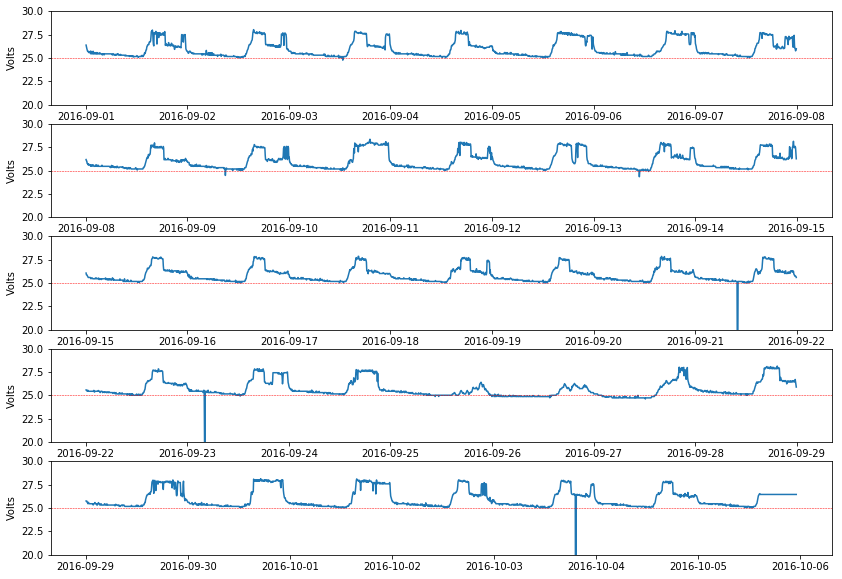

In [7]:
site = 'AN06'
wks = 5 # to see the full dataset, set wks=120
fig, ax = plt.subplots(wks, 1, sharex=False, figsize=(14, wks*2))
en_date = pd.to_datetime('20160901', format='%Y%m%d')

for i in range(wks):
    st_date = en_date
    en_date = st_date + datetime.timedelta(days=7)
    plot_SOH(Volt_df, site, st_date, en_date, ylims=(20,30), ylabel='Volts', ax=ax[i])
    

### Distinctive Voltage Profiles (Solar Power):

After visual inspection of the above battery voltages, we point out four distinct windows that are representative of four common operating conditions:

- 2016-09-15 (Good)

- 2016-11-19 (OK)

- 2017-02-18 (Short Outage)

- 2018-12-05 (Extended Outage)


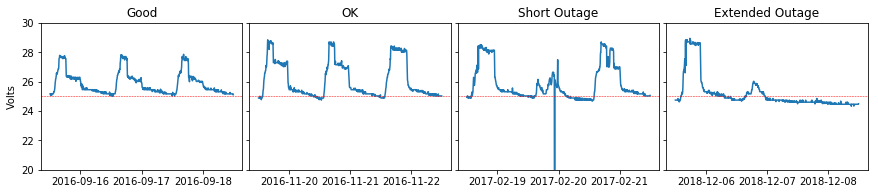

In [10]:
fig, ax = plt.subplots(1, 4, sharey=True, figsize=(12, 2.5))

sites = ['AN06', 'AN06', 'AN06', 'AN06']
dates = ['20160915', '20161119', '20170218', '20181205']
labels = ['Good', 'OK', 'Short Outage', 'Extended Outage']

for i, (site, date, label) in enumerate(zip(sites, dates,labels)):
    
    st_date = pd.to_datetime(date, format='%Y%m%d')  + datetime.timedelta(days=.5)
    en_date = st_date + datetime.timedelta(days=3)
    plot_SOH(Volt_df, site, st_date, en_date, ax=ax[i], rot=0)
    ax[i].set_title(label)
    ax[i].xaxis.set_major_locator(mdates.DayLocator())
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax[0].set_ylabel('Volts')
fig.tight_layout(pad=0.0, w_pad=0, h_pad=0)
plt.savefig(f'VoltageProfiles_PV.png', transparent=False)


These four plots represent four distinct voltage profiles discovered through visual inspection:

__Plot 1 [Good]__ - This plot is representenative of approximately 9 months out of the year at location AN. The batteries are connected to a regular PV power source, and the voltage is maintained above 25V. This voltage profile is desired, and should not prompt an alert to maintenance personnel..

__Plot 2 [OK]__ - This plot is representative of the wintertime months at location AN, approximately 3 months out of the year. The batteries are still connected to a regular PV power source, however the days are shorter, and the voltage regularly dips below 25V. This voltage profile is anticipated, and should not prompt an alert to maintenance personnel.

__Plot 3 [Short Outage]__ - This plot represents a short outage of the PV power. This particular outage occurs during the winter, on a cloudy day. This voltage profile is anticipated, and should not prompt an alert to maintenance personnel.

__Plot 4 [Extended Outage]__ - This plot represents an extended outage of the PV power feed. This voltage profile is dangerous, as these outages can sometimes last several days, draining the batteries beyond the Low Voltage Disconnect and causing equipment failure. This voltage profile should prompt an alert to maintenance personnel.

### Visual Exploration of Battery Voltage at a Commercial Power Site (AE)

To begin, we pick a commercially powered equipment site, in this case location AE, and plot the full 120 weeks of SOH Voltage Data. We investigage these plots visually, looking for any distinctive voltage profiles that are common throughout.

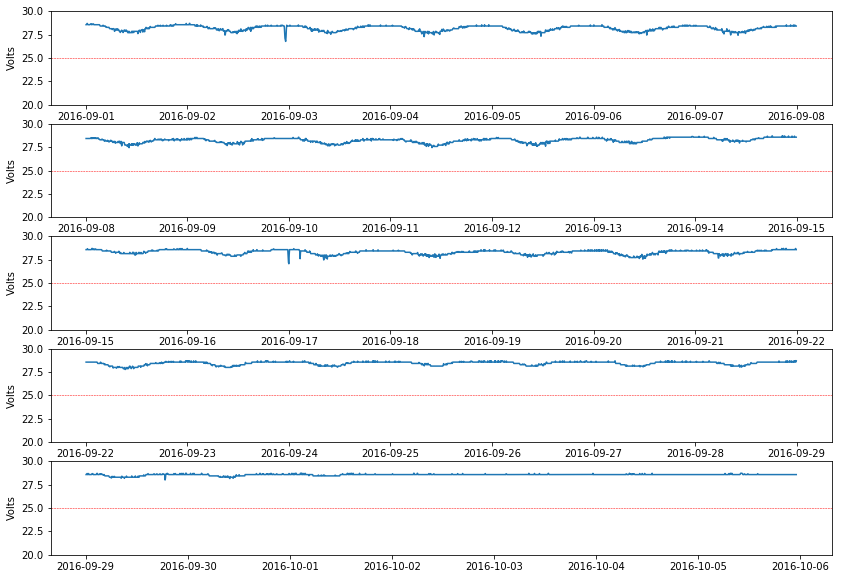

In [11]:
site = 'AE04'
wks = 5 # to see the full dataset, set wks=120 
fig, ax = plt.subplots(wks, 1, sharex=False, figsize=(14, wks*2))
en_date = pd.to_datetime('20160901', format='%Y%m%d')

for i in range(wks):
    st_date = en_date
    en_date = st_date + datetime.timedelta(days=7)
    plot_SOH(Volt_df, site, st_date, en_date, ylims=(20,30), ylabel='Volts', ax=ax[i])
    

### Distinctive Voltage Profiles (Commercial Power):

After visual inspection of the above battery voltages, we point out four distinct windows that are representative of four common operating conditions:

- 2016-10-15 (Good)

- 2017-07-07 (OK)

- 2017-12-07 (Short Outage)

- 2018-11-30 (Extended Outage)


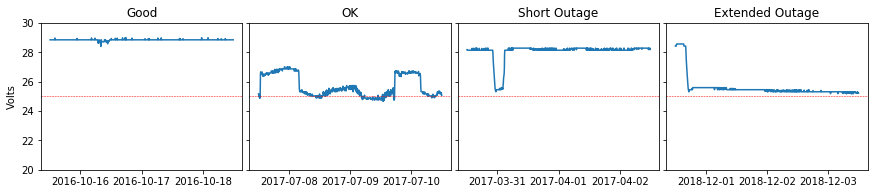

In [12]:
fig, ax = plt.subplots(1, 4, sharey=True, figsize=(12, 2.5))

sites = ['AE03', 'AE05', 'AE07', 'AE04']
dates = ['20161015', '20170707', '20170330', '20181130']
labels = ['Good', 'OK', 'Short Outage', 'Extended Outage']

for i, (site, date, label) in enumerate(zip(sites, dates,labels)):
    
    st_date = pd.to_datetime(date, format='%Y%m%d')  + datetime.timedelta(days=.5)
    en_date = st_date + datetime.timedelta(days=3)
    plot_SOH(Volt_df, site, st_date, en_date, ax=ax[i], rot=0)
    ax[i].set_title(label)
    ax[i].xaxis.set_major_locator(mdates.DayLocator())
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax[0].set_ylabel('Volts')
fig.tight_layout(pad=0.0, w_pad=0, h_pad=0)
plt.savefig(f'VoltageProfiles_AC.png', transparent=False)


These four plots represent four distinct voltage profiles discovered through visual inspection:

__Plot 1 [Good]__ - This plot is representenative of approximately 9 months out of the year at location AE. The batteries are connected to a steady DC power source, rectified and regulated from the commercial AC power feed. This voltage profile is desired, and should not prompt an alert to maintenance personnel..

__Plot 2 [OK]__ - This plot is representative of the summertime months at location AE, approximately 3 months out of the year. The batteries are still connected to the rectified DC power source, however the commercial AC feeding it is rather unreliable, and subject to diurnal brownouts. This voltage profile is anticipated, and should not prompt an alert to maintenance personnel.

__Plot 3 [Short Outage]__ - This plot represents a short outage of the commercial AC power. This particular outage occurs during the non-summer months, and occurs frequently throughout the year. This voltage profile is anticipated, and should not prompt an alert to maintenance personnel.

__Plot 4 [Extended Outage]__ - This plot represents an extended outage of the commercial AC power feed. This voltage profile is dangerous, as these outages can sometimes last several days, draining the batteries beyond the Low Voltage Disconnect and causing equipment failure. This voltage profile should prompt an alert to maintenance personnel.

### Problem with Static Thresholds:

Although the extended outages shown above are trivial to identify visually, they impossible to identify via a static threshold. Even with a low threshold of 25VDC, false alarms would be sent almost daily during certain months, while an extended outage could go on for days before it was recognized. Clearly, static thresholds are inappropriate for setting operational alarms on the battery voltage SOH data.

---
## STEP 2: DEFINE AND TRAIN THE SIAMESE-SHIFT ENCODER
---

As demonstrated above, static thresholding is generally inappropriate for identifying fault conditions for battery voltage. Instead, we desire a more wholistic method of identifying the extended outage voltage profiles shown above for both Commercial Power and Solar Power equipment sites. This task would be easily accomplished by a 1D Convolutional NN classifier, if enough training examples were available... unfortunately this is not the case. Instead, we shall rely on a semi-supervised learning method known as the Siamese Neural Network, most commonly used in facial recognition.



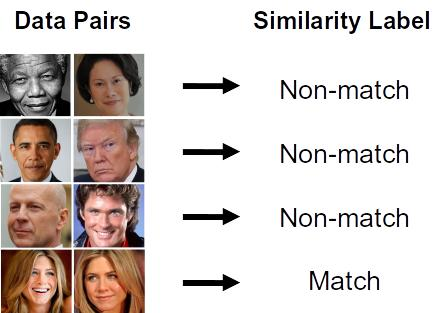

In [25]:
Image("img/SiameseFaces.jpg")

Instead of training a binary classifier, which needs many examples of each class, the Siamese neural network is a similarity metric. It is trained to determine whether or not two images are a match. This means that once the network is trained, it can be used for detection (binary classification) based on template matching. 

This works well for faces, where there is an obvious definition for 'Match'. But how can we employ this technique for unlabeled time-series data? The answer is the siamese-shift encoder. On average, time-series windows that are temporally near (overlapping) will share common features useful for anomoly detection moreso that time-series windows that are temporally far. This is demonstrated in the plot below, where the green windows are overlapping and thus defined as a match, while the red windows are disparate and are thus defined as a non-match. These identities can be used to train a siamese neural network as in facial recognition. 

Because the resultant encodings are robust to temporal shifts, we call it the siamese-shift encoder.

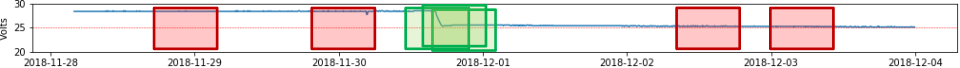

In [27]:
Image("img/Voltage_week_shift.png")

In the diagram below, you can see that any overlapping pairs are labeled as "Match", whereas the non-overlapping pairs are labeled as "Non-match".

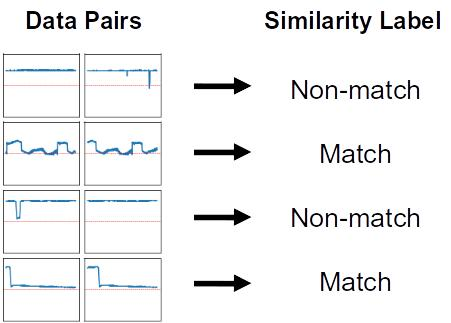

In [28]:
Image("img/SiameseTraces.jpg")

### Define the Generator Function

We then use a generator function to create batches of data windows, where each window is given an ID based on its general locality in the datastream, and the batch includes K unique IDs with P examples of each ID, for a total batch size of P\*K. This general arrangement is used to support the batch-hard loss function, which we shall soon examine in detail.

In [16]:
def generator_hard(SOH_df, n_P=10, n_K=10, wind_siz_days=2, shft_siz_days=1, sampsPerDay=int(60*24/5), return_string=False):
    
    # Extract information about the SOH dataframes
    sites = [col for col in list(SOH_df.columns) if col not in ['TIME', 'DATE']]
        
    df_samps = len(SOH_df)
    _df_samps = df_samps - sampsPerDay*(wind_siz_days+shft_siz_days)
    
    wind_samps = int(wind_siz_days*sampsPerDay)
    shft_samps = int(shft_siz_days*sampsPerDay)
    
    bs = n_P*n_K

    while 1:

        # Declare variables to store the inputs (x) and outputs (labels) for a single batch
        labels_string = []
        labels = np.zeros(bs)
        x = np.zeros((bs, wind_samps, 1))
        
        i = 0
        while i < n_P:
            
            site = random.choice(sites)
            samp = np.random.randint(_df_samps)
            
            my_seq = SOH_df.loc[range(samp, samp + wind_samps + shft_samps), site].values
            #print(i, site, samp, sum(np.isnan(my_seq)))
            if sum(np.isnan(my_seq)) == 0:
                for j in range(n_K):
                    batch_idx = i*n_K + j
                    st_samp = np.random.randint(shft_samps)
                    en_samp = st_samp + wind_samps
                    x[batch_idx,:,0] = my_seq[st_samp:en_samp]
                    labels[batch_idx] = i
                    labels_string.append(f'{site}_{SOH_df.iloc[samp].TIME}')
                i += 1

        if return_string:
            yield x, labels_string
        else:
            yield x, labels.astype(int)


### Partition the dataset into Train/Val/Test

In [17]:
trn_time = pd.to_datetime('20160901', format='%Y%m%d')
val_time = pd.to_datetime('20180601', format='%Y%m%d')
tst_time = pd.to_datetime('20180901', format='%Y%m%d')
en_time = pd.to_datetime('20190101', format='%Y%m%d')

Volt_df_trn = pd.DataFrame()
Volt_df_val = pd.DataFrame()
Volt_df_tst = pd.DataFrame()

Volt_df_trn = Volt_df.loc[(Volt_df['TIME'] >= trn_time) & (Volt_df['TIME'] < val_time)].reset_index(drop=True)
Volt_df_val = Volt_df.loc[(Volt_df['TIME'] >= val_time) & (Volt_df['TIME'] < tst_time)].reset_index(drop=True)
Volt_df_tst = Volt_df.loc[(Volt_df['TIME'] >= tst_time) & (Volt_df['TIME'] < en_time)].reset_index(drop=True)

In [18]:
tst_gen = generator_hard(Volt_df_tst, return_string=True)
x,y = next(tst_gen)

print(x.shape)

(100, 576, 1)


### Define the NN Architecture

The NN Architecture used here is the Temporal Convolutional Network, which consists of stacked layers of dilated convolutions, along with residual and skip connections.

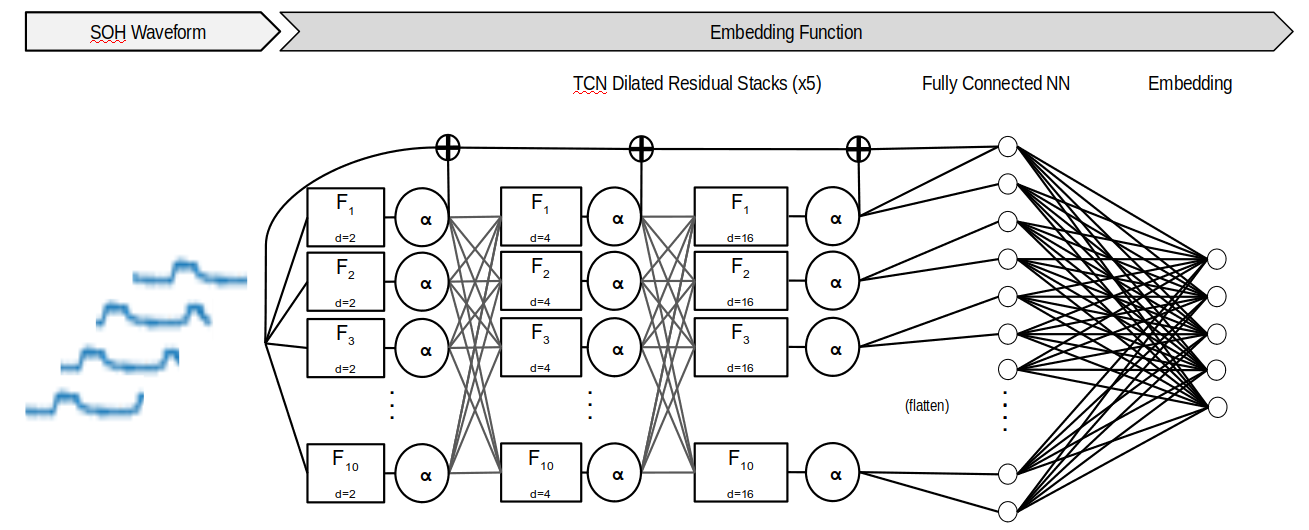

In [29]:
Image("img/ShiftEncoder.png")

In [20]:
def channel_normalization(x):
    # Normalize by the highest activation
    max_values = K.max(K.abs(x), 2, keepdims=True) + 1e-5
    out = x / max_values
    return out


def residual_block(x, s, i, nb_filters, kernel_size):
    original_x = x
    conv = Conv1D(filters=nb_filters, kernel_size=kernel_size,
                  dilation_rate=2 ** i, padding='same',
                  name='dilated_conv_%d_tanh_s%d' % (2 ** i, s))(x)
    x = Activation('relu')(conv)
    x = Lambda(channel_normalization)(x)
    x = SpatialDropout1D(0.05)(x)

    # 1x1 conv.
    x = Convolution1D(nb_filters, 1, padding='same')(x)
    res_x = keras.layers.add([original_x, x])
    return res_x, x


def encoder_network(input_shape, nb_filters, kernel_size, dilatations, nb_stacks, norm=False, out_dim=16):
    activation = 'relu'
    input_layer = Input(name='input_layer', shape=input_shape)
    x = input_layer
    x = Convolution1D(nb_filters, kernel_size, padding='same', name='initial_conv')(x)

    skip_connections = []
    for s in range(nb_stacks):
        for i in dilatations:
            x, skip_out = residual_block(x, s, i, nb_filters, kernel_size)
            skip_connections.append(skip_out)

    x = keras.layers.add(skip_connections)
    x = Activation('relu')(x)

    x = Conv1D(1, kernel_size=kernel_size, activation=activation)(x)  # CONV1D

    # regression
    x = Flatten()(x)
    x = Dense(out_dim)(x)
    x = Activation('linear', name='output_dense')(x)

    # normalize output for cosine similarity
    if norm:
        x = Lambda(lambda xx: K.l2_normalize(xx, axis=1))(x)

    output_layer = x
    print(f'model.x = {input_layer.shape}')
    print(f'model.y = {output_layer.shape}')
    model = Model(input_layer, output_layer, name='encoder_model')

    return model

### Define the Loss Function

We next implement the batch-hard loss function.

For each example in the batch, X<sub>u</sub><sup>(v)</sup>, we wish to build a hard triple. The hardest positive is the matched-id example (same v) with the farthest embedding space distance D(). The hardest negative is the non-matched-id example (different v) with the nearest embedding space distance D(). 

Algorithmically, this can be accomplished by forward propagating the batch through the neural network, and then forming a distance matrix between all pairs of embeddings. For each row, matched-id and non-matched-id distances can then be masked (green and red, respectively), and mined (max of green and min of red, respectively). 

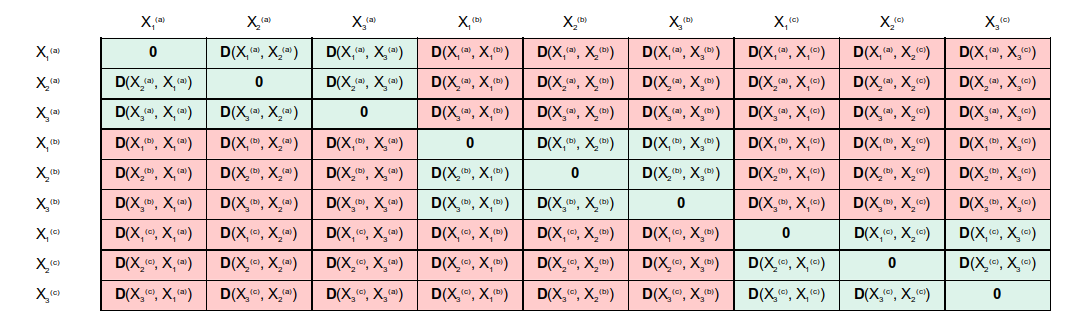

In [30]:
Image("img/BatchHard.png")

In [22]:
def get_pairwise_dists(x, num_p, num_k):
    # pairwise distances for whole batch
    # (redundant computation but probably still faster than alternative)
    norms = tf.reduce_sum(x * x, 1)
    norms = tf.reshape(norms, [-1, 1])
    dists = norms - 2 * tf.matmul(x, x, transpose_b=True) + tf.transpose(norms)
    dists = K.sqrt(K.relu(dists))

    # get the max intra-class distance for each sample
    max_pos = [tf.reduce_max(tf.slice(dists, [i * num_k, i * num_k], [num_k, num_k]), axis=1) for i in range(0, num_p)]
    max_pos = K.concatenate(max_pos, axis=0)

    # get the min inter-class distance for each sample
    min_neg = []
    for i in range(0, num_p):
        left = tf.slice(dists, [i * num_k, 0], [num_k, i * num_k])
        right = tf.slice(dists, [i * num_k, (i + 1) * num_k], [num_k, (num_p - i - 1) * num_k])
        min_neg.append(tf.reduce_min(K.concatenate([left, right], axis=1), axis=1))
    min_neg = K.concatenate(min_neg, axis=0)

    min_max = K.concatenate([K.expand_dims(max_pos, axis=-1), K.expand_dims(min_neg, axis=-1)], axis=1)
    return min_max, dists


def get_triplet_dists(x, margin=0.5):
    x = K.transpose(x)
    max_pos = tf.gather(x, 0)
    min_neg = tf.gather(x, 1)
    # Use relu or softplus
    L_triplet = K.expand_dims(K.softplus(margin + max_pos - min_neg), 1)
    return L_triplet


def get_loss_acc(n_P, n_K, alpha=.001, margin=0.5):
    def triplet_loss(y_true, y_pred):
        min_max_dists, all_dists = get_pairwise_dists(y_pred, n_P, n_K)
        loss1 = get_triplet_dists(min_max_dists, margin)
        loss2 = 1 / (all_dists + 1e-8)
        return K.mean(loss1) + alpha * K.mean(loss2)

    def triplet_acc(y_true, y_pred):
        dists, _ = get_pairwise_dists(y_pred, n_P, n_K)
        loss = get_triplet_dists(dists, margin)
        pos = K.less(loss, .5)
        return K.mean(pos)

    return triplet_loss, triplet_acc

### Train the Siamese-Shift Encoder

The code below will train a Siamese-Shift encoder on the data. In case the network completly fails to converge within the first couple epochs, please rerun the cell again.

In [24]:
# OS Parameters
model_folder = 'models'
log_folder = 'logs'

if not os.path.exists(model_folder):
    os.makedirs(model_folder)
if not os.path.exists(log_folder):
    os.makedirs(log_folder)
    
# Model Parameters
pat = 10
d = [1, 2, 4]
k = 15
s = 2
f = 50
od = 5
n = 1
ponly = True

wind_siz_days=2
shft_siz_days_list=[.075, .1, .2]
samps_per_day=24*60/5

numP=5
numK=5

t_len = 10000
v_len = 1000
t_step = t_len//(numP*numK)+1
v_step = v_len//(numP*numK)+1




## Load the Model
# model = 'models/FaultNet_hard--1.1e-06a_9e-05lr_5P_5K_50f_15k_2s_1x2x4d_1n_0.2m_2win_0.1sft_4od_20pat_1strms.h5'
model = None

if model == None:
    ld = 0
    encoder_model = encoder_network(input_shape=(wind_siz_days*samps_per_day, 1), nb_filters=f, kernel_size=k, dilatations=d, nb_stacks=s, norm=n, out_dim=od)
else:
    ld = 1
    encoder_model = load_model(model, custom_objects={'triplet_loss': my_loss, 'triplet_acc': my_acc})

# Optimization Parameters
lr = 0.0001
m = 0.2
a = 0.0000001
# a = 0

my_loss, my_acc = get_loss_acc(numP, numK, a, m)
o = optimizers.Adam(lr=lr, clipnorm=1.)

## Compile the Model
encoder_model.compile(loss=my_loss, optimizer=o, metrics=[my_acc])

## Train the Model

for shft_siz_days in shft_siz_days_list:
    train_gen = generator_hard(Volt_df_trn, numP, numK, wind_siz_days, shft_siz_days)
    val_gen = generator_hard(Volt_df_val, numP, numK, wind_siz_days, shft_siz_days)

    str_d = str(d).replace('[', '').replace(']', '').replace(',', 'x').replace(' ', '')
    name = f'FaultNet_hard--{a}a_{lr}lr_{numP}P_{numK}K_{f}f_{k}k_{s}s_{str_d}d_{n}n_{m}m_{wind_siz_days}win_{shft_siz_days}sft_{od}od_{pat}pat{ld}'
    model_filename = os.path.join(os.getcwd(), model_folder, name + '.h5')
    print(model_filename)
    tensor_foldername = os.path.join(os.getcwd(), log_folder, name)

    sv = keras.callbacks.ModelCheckpoint(filepath=model_filename, monitor='val_triplet_acc', save_best_only=True, save_weights_only=False, mode='max')
    tbd = keras.callbacks.TensorBoard(log_dir=tensor_foldername)
    stp = keras.callbacks.EarlyStopping(monitor='val_triplet_acc', min_delta=0, patience=pat, verbose=0, mode='max', baseline=None)



    encoder_model.summary()
    history = encoder_model.fit_generator(train_gen, steps_per_epoch=t_step, epochs=5000,
                                          validation_data=val_gen, validation_steps=v_step,
                                          callbacks=[sv, tbd, stp], max_queue_size=10)

# encoder_model = load_model(model_filename, custom_objects={'triplet_loss': my_loss, 'triplet_acc': my_acc})

model.x = (?, 576, 1)
model.y = (?, 5)
/media/NAS/PycharmProjects/FaultNetSmall/models/FaultNet_hard--1e-07a_0.0001lr_5P_5K_50f_15k_2s_1x2x4d_1n_0.2m_2win_0.075sft_5od_10pat0.h5
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        (None, 576.0, 1)     0                                            
__________________________________________________________________________________________________
initial_conv (Conv1D)           (None, 576.0, 50)    800         input_layer[0][0]                
__________________________________________________________________________________________________
dilated_conv_2_tanh_s0 (Conv1D) (None, 576.0, 50)    37550       initial_conv[0][0]               
__________________________________________________________________________________________________
activation_8 (Activation)     

Epoch 1/5000
401/401 [==============================] - 10s 24ms/step - loss: 1.1070 - triplet_acc: 0.0559 - val_loss: 1.0229 - val_triplet_acc: 0.3366
Epoch 2/5000
401/401 [==============================] - 9s 21ms/step - loss: 1.0185 - triplet_acc: 0.2393 - val_loss: 1.0037 - val_triplet_acc: 0.3395
Epoch 3/5000
401/401 [==============================] - 9s 22ms/step - loss: 1.0104 - triplet_acc: 0.2548 - val_loss: 1.0176 - val_triplet_acc: 0.3854
Epoch 4/5000
401/401 [==============================] - 9s 22ms/step - loss: 1.0028 - triplet_acc: 0.2713 - val_loss: 1.0102 - val_triplet_acc: 0.3620
Epoch 5/5000
401/401 [==============================] - 9s 22ms/step - loss: 0.9887 - triplet_acc: 0.2810 - val_loss: 0.9737 - val_triplet_acc: 0.4459
Epoch 6/5000
401/401 [==============================] - 9s 22ms/step - loss: 0.9900 - triplet_acc: 0.2842 - val_loss: 1.0112 - val_triplet_acc: 0.3873
Epoch 7/5000
401/401 [==============================] - 9s 22ms/step - loss: 0.9930 - triplet

Epoch 1/5000
401/401 [==============================] - 9s 22ms/step - loss: 0.9857 - triplet_acc: 0.2917 - val_loss: 1.0041 - val_triplet_acc: 0.3132
Epoch 2/5000
401/401 [==============================] - 9s 22ms/step - loss: 0.9903 - triplet_acc: 0.2838 - val_loss: 0.9804 - val_triplet_acc: 0.3220
Epoch 3/5000
401/401 [==============================] - 9s 22ms/step - loss: 0.9770 - triplet_acc: 0.2931 - val_loss: 1.0183 - val_triplet_acc: 0.2761
Epoch 4/5000
401/401 [==============================] - 9s 22ms/step - loss: 0.9788 - triplet_acc: 0.2844 - val_loss: 0.9707 - val_triplet_acc: 0.3961
Epoch 5/5000
401/401 [==============================] - 9s 21ms/step - loss: 0.9784 - triplet_acc: 0.2783 - val_loss: 0.9963 - val_triplet_acc: 0.3229
Epoch 6/5000
401/401 [==============================] - 9s 22ms/step - loss: 0.9903 - triplet_acc: 0.2849 - val_loss: 1.0764 - val_triplet_acc: 0.1629
Epoch 7/5000
401/401 [==============================] - 9s 22ms/step - loss: 0.9963 - triplet_

Epoch 1/5000
401/401 [==============================] - 9s 22ms/step - loss: 1.0853 - triplet_acc: 0.1424 - val_loss: 1.0888 - val_triplet_acc: 0.1922
Epoch 2/5000
401/401 [==============================] - 9s 22ms/step - loss: 1.0694 - triplet_acc: 0.1708 - val_loss: 1.1122 - val_triplet_acc: 0.1776
Epoch 3/5000
401/401 [==============================] - 9s 22ms/step - loss: 1.0708 - triplet_acc: 0.1611 - val_loss: 1.0830 - val_triplet_acc: 0.2234
Epoch 4/5000
401/401 [==============================] - 9s 22ms/step - loss: 1.0556 - triplet_acc: 0.1879 - val_loss: 1.0885 - val_triplet_acc: 0.2088
Epoch 5/5000
401/401 [==============================] - 9s 22ms/step - loss: 1.0630 - triplet_acc: 0.1820 - val_loss: 1.0296 - val_triplet_acc: 0.3073
Epoch 6/5000
401/401 [==============================] - 9s 22ms/step - loss: 1.0651 - triplet_acc: 0.1631 - val_loss: 1.0871 - val_triplet_acc: 0.1698
Epoch 7/5000
401/401 [==============================] - 9s 22ms/step - loss: 1.0506 - triplet_

---
## STEP 3: LOAD THE LABELED TEST SET
---

We now load a hand-labeled test set, which contains all two-day windows found in the test set staggered with a one-day overlap. The windows are labeled across six categories, including:

- Array Name

- Power Type (commercial vs solar)

- Nominal Voltage (12V vs 24V)

- AC_outage (Binary field indicating the presence of an extended commercial AC outage)

- PV_outage (Binary field indicating the presence of an extended Solar outage)

In [31]:
Data_tst = pd.read_csv('data/DataSet_tst_orig.csv')
Data_tst['Date'] = pd.to_datetime(Data_tst['Date']).dt.date

### Load the Embedding Model

In [32]:
my_loss, my_acc = get_loss_acc(10, 10, 0, .2)
o = optimizers.Adam(lr=.001, clipnorm=1.)

## Compile the Model
encoder_model = load_model(model_filename, custom_objects={'triplet_loss': my_loss, 'triplet_acc': my_acc})
encoder_model.compile(loss=my_loss, optimizer=o, metrics=[my_acc])

### Embed the Test Set Windows

In [33]:
def feat_ext(model, DataSet):
    x = DataSet[[c for c in DataSet.columns if c[0] == 'x']].values
    X = model.predict(np.expand_dims(x, axis=2))
    feat = pd.DataFrame(X, columns = [f'X{i:03d}' for i in range(X.shape[1])])
    DataSet = pd.concat([DataSet, feat], axis=1)
    return DataSet
    

In [34]:
Data_tst = feat_ext(encoder_model, Data_tst)
Embd_tst = Data_tst[[c for c in Data_tst.columns if c[0] == 'X']].values

### Generate t-SNE Encodings for 2D Visualization

This only needs to be accomplished once. After the first run of the code, the first two lines can be commented out, as the results are stored locally.

In [35]:
Tsne_tst = tsne.fit_transform(Embd_tst)
np.save('data/Tsne_tst.npy', Tsne_tst)
Tsne_tst = np.load('data/Tsne_tst.npy')

---
## STEP 4: ANALYSIS OF THE ENCODINGS AGAINST THE TEST SET
---

### Define the Plotting and Clustering Tools Used in FaultNet

In [36]:
def plot_SOH_2(df, site, date, ylims=(20,30), ylabel='', rot=0, ax=None, hline=25):
    ax = ax or plt.gca()
    ax.cla()
    
    my_df = df.loc[(df.Site == site) & (df.Date == date)]
    y = my_df[[f'x{i:03d}' for i in range(576)]].values[0]
    ax.plot(y, markersize=0, linestyle='-')
    ax.axhline(hline, color='red', ls='--', lw=.5)
    ax.set_ylim(ylims)
    ax.set_ylabel(ylabel)
    return y

In [37]:
def plot_by_class(df, feat, max_cl=999, max_ex=7, cls=None, my_lbl=''):
    """ Create a multiplot for the classes in feat
        the classes are enumerated by row, with sampled
        examples (up to max_ex) plotted in each column.

    Args:
        df: (DataFrame) the dataframe containing the data
        feat: (list) df columns to pivot on
        max_cl: (scalar) maximum number of classes to detail
        max_ex: (scalar) maximum number of examples per class
    """
    if cls is None:
        cls = top_n_cl(df, feat, max_cl)

    plt_w = 10
    plt_h = .8*len(cls)
    ttl_h = .5
    
    indices = []

    fig, axes = plt.subplots(len(cls), max_ex, sharey=True, figsize=(plt_w,plt_h+ttl_h))
    for i, cl in enumerate(cls):
        nb_ex = min(max_ex, len(df.loc[df[feat] == cl]))
        df_ex = df.loc[df[feat] == cl].sample(nb_ex, replace=False).reset_index()
        for j, ex in df_ex.iterrows():
            x = ex[[f'x{i:03d}' for i in range(576)]].values
            axes[i,j].plot(x)
            axes[i,j].set_yticks([axes[i,j].get_ylim()[1]])
            if my_lbl == 'site':
                axes[i,j].set_title(f'{ex.Site}')
            if my_lbl == 'index':              
                axes[i,j].set_title(f'{ex["Array"]}: {ex["index"]}')
                indices.append(ex["index"])
            #axes[i,j].get_yaxis().set_major_formatter(xfmt)
            axes[i,j].set_ylim((10,30))
            axes[i,j].get_yaxis().set_ticks([10,30])
            axes[i,j].get_xaxis().set_ticks([])
        for jj in range(j+1,max_ex):
            axes[i,jj].get_yaxis().set_ticks([])
            axes[i,jj].get_xaxis().set_ticks([])
        axes[i,0].set_ylabel(f'CL:{cl}\n({len(df.loc[df[feat] == cl])})', rotation=0, fontsize=14, labelpad=40, horizontalalignment='right')    

    fig.suptitle(f'{feat}', fontsize=18)
    fig.tight_layout(pad=0.0, w_pad=0, h_pad=0)
    fig.subplots_adjust(top=plt_h/(plt_h+ttl_h)-.00008*len(cls))
    
    if my_lbl == 'index':
        return indices
    else:
        return

    
def scatter(x, labels, subtitle=None, ax=None, annotate=True, sizes=None):
    ax = ax or plt.gca()
    ax.cla()
    
    # We choose a color palette with seaborn.
    dict = {label:i for i, label in enumerate(set(labels))}
    palette = np.array(sns.color_palette("hls", len(np.unique(labels))))
    if sizes is None:
        sizes = np.array([40]*len(np.unique(labels)))

    # We create a scatter plot.
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=sizes[[dict[l] for l in labels]],
                    c=palette[[dict[l] for l in labels]], label=labels)
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)
    #ax.axis('off')
    ax.axis('tight')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
    # We add the labels for each digit.
    if annotate:
        txts = []
        for i in np.unique(labels):
            # Position of each label.
            xtext, ytext = np.median(x[labels == i, :], axis=0)
            txt = ax.text(xtext, ytext, str(i), fontsize=12)
            txt.set_path_effects([
                PathEffects.Stroke(linewidth=5, foreground="w"),
                PathEffects.Normal()])
            txts.append(txt)
    else:
        pass
        #plt.legend()
        
    if subtitle != None:
        ax.set_xlabel(subtitle, fontsize=18)
        
    #plt.show()

In [38]:
def get_k_range(min_k, max_k):
    min_k = max(min_k, 2)
    return [i for i in range(min_k,max_k+1)]

def cluster_and_score(xin, k_range, cluster_alg='kmeans', all_labels=False, return_scores=False):
    scores = np.zeros(len(k_range))
    labels = np.zeros((len(k_range), len(xin)), dtype=int)
    
    for i, n in enumerate(k_range):
        print(f'Clustering data with k={n}...', end=' ')
        if cluster_alg == 'kmeans':
            KM = KMeans(n_clusters=n, random_state=0, n_jobs=-2)
            labels[i,:] = KM.fit_predict(xin)
            scores[i] = silhouette_score(xin, labels[i,:], metric='euclidean')
        elif cluster_alg == 'agg':
            np.random.seed(0)
            AG = AgglomerativeClustering(n_clusters=n, affinity='precomputed', linkage='average')
            labels[i,:] = AG.fit_predict(xin)
            scores[i] = silhouette_score(xin, labels[i,:], metric='precomputed')
        else:
            print('not a valid clustering algorithm!')
            return
        
        print(f'score={scores[i]:0.9f}')
        
    best_idx = np.argmax(scores)
    print(f'The best k is {k_range[np.argmax(scores)]} with a silhoette score of {max(scores):0.2f}')

    return list(np.round(scores,3)), labels, best_idx
    

def calc_and_infer(df, lbl, feat, th=0.10):
    maxs = [0]*len(lbl)
    maxc = ['']*len(lbl)
    maxp = [0]*len(lbl)
    totc = [0]*len(lbl)    
    for i in range(len(lbl)):
        k = i+2
        my_feature = f'{feat}_{k}'
        df[my_feature] = pd.Series(lbl[i])
        p, c = df_pivot(df, my_feature, print_out=False)
        maxp[i] = np.max(p)
        totc[i] = np.sum(np.where(p>=th, 1, 0)*c)

        for meta_feat in ['TS','CR','TC','OT','TM','DN']:
            s = np.round(get_feat_corr(df, my_feature, meta_feat, th=.5, print_out=False),2)
            maxs[i] = max(maxs[i], s)
            if s >= maxs[i]:
                maxc[i] = meta_feat
    return df, maxs, maxc, maxp, totc


def get_feat_corr(df, f1, f2, th=.1, print_out=True):
    no_corr = True
    lb = LabelBinarizer()

    f1_l = lb.fit_transform(df[f1].values)
    f1_c = lb.classes_
    f2_l = lb.fit_transform(df[f2].values)
    f2_c = lb.classes_


    for i in range(f1_l.shape[1]):
        for j in range(f2_l.shape[1]):
            s = v_measure_score(f1_l[:,i], f2_l[:,j])
            if s > th:
                no_corr = False
                if print_out:
                    print(f'{f1}={f1_c[i]} & {f2}={f2_c[j]} match with a v_measure of {s:.03f}')
    if no_corr & print_out:
        print(f'no significant correlations found between {f1} and {f2}')
        
    return s

In [39]:
def top_n_cl(df, c, n):
    cl = list(df[c].value_counts().index)
    return cl[:min(n, len(cl))]

def df_pivot(df, feat, max_cl=999, print_out=True):
    """ Create a pivot table for the classes in feat

    Args:
        df: (DataFrame) the dataframe containing the data
        feat: (list) df columns to pivot on
        max_cl: (scalar) maximum number of classes to detail
    """
    cls = top_n_cl(df, feat, max_cl)
    pval = np.zeros(len(cls))
    cnt = np.zeros(len(cls)).astype(int)
    if print_out:
        print(f'\n{feat}:\tCOUNT\n'+21*'-')
    for i, cl in enumerate(cls):
        x = np.array(df.loc[df[feat] == cl][[f'x{i:03d}' for i in range(576)]].values)
        cnt[i] = int(len(x))

        if print_out:
            print(f'{cl}: \t{int(cnt[i]):05d}')
    return pval, cnt

### Visualize TestSet by known class (Nominal Voltage):


NOM_VLT:	COUNT
---------------------
24V: 	12661
12V: 	03921


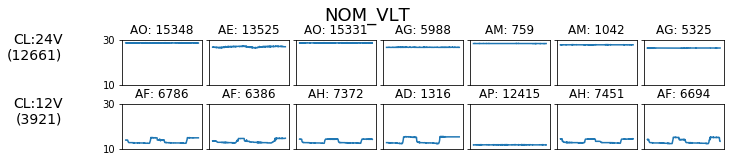

In [40]:
feature = 'NOM_VLT'
df_pivot(Data_tst, feature)
plot_by_class(Data_tst, feature, my_lbl='index')
plt.savefig(f'{feature}.png', transparent=True)

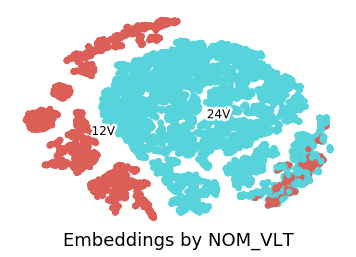

In [41]:
scatter(Tsne_tst, Data_tst[feature].values, f'Embeddings by {feature}')

### Visualize TestSet by known class (Power Type):


PWR_TYPE:	COUNT
---------------------
24V_comml: 	08624
24V_solar: 	04037
12V_solar: 	03114
12V_comml: 	00807


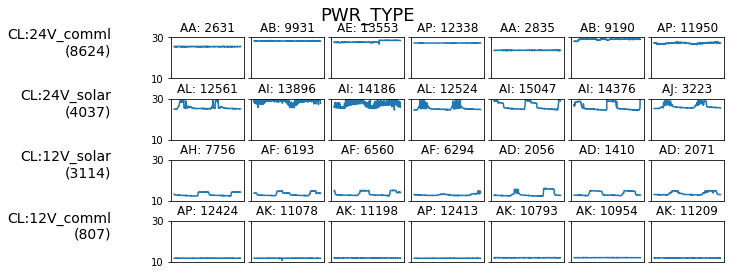

In [42]:
feature = 'PWR_TYPE'
df_pivot(Data_tst, feature)
plot_by_class(Data_tst, feature, my_lbl='index')
plt.savefig(f'{feature}.png', transparent=True)

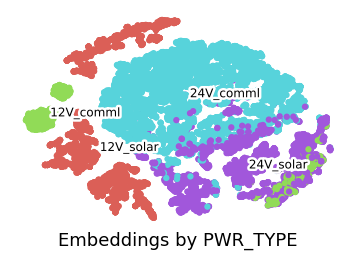

In [43]:
scatter(Tsne_tst, Data_tst[feature].values, f'Embeddings by {feature}')

### Visualize TestSet by known class (Outage Type):


Outage_type:	COUNT
---------------------
None: 	16434
PV: 	00112
AC: 	00036


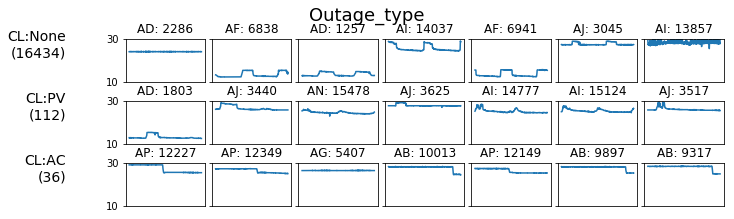

In [44]:
Data_tst['Outage_type'] = 'None'
Data_tst.loc[Data_tst.AC_outage == 1, 'Outage_type'] = 'AC'
Data_tst.loc[Data_tst.PV_outage == 1, 'Outage_type'] = 'PV'

feature = 'Outage_type'
df_pivot(Data_tst, feature)
plot_by_class(Data_tst, feature, my_lbl='index')
plt.savefig(f'{feature}.png', transparent=True)

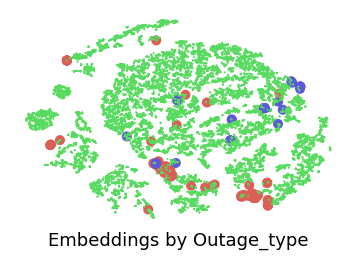

In [45]:
scatter(Tsne_tst, Data_tst[feature].values, f'Embeddings by {feature}', sizes=np.array([100,4,100]), annotate=False)

### Cluster based on Embeddings:

In [35]:
feature = 'DTC_CL'
k_lo = 2
k_hi = 15
score_df = pd.DataFrame(columns = [f'k={k}' for k in get_k_range(k_lo, k_hi)])
score_df.loc[feature], labels, idx = cluster_and_score(Embd_tst, get_k_range(k_lo, k_hi), 'kmeans')

Clustering data with k=2... score=0.490623037
Clustering data with k=3... score=0.500880281
Clustering data with k=4... score=0.563831255
Clustering data with k=5... score=0.582015406
Clustering data with k=6... score=0.548470777
Clustering data with k=7... score=0.552616141
Clustering data with k=8... score=0.530923511
Clustering data with k=9... score=0.528220257
Clustering data with k=10... score=0.494222137
Clustering data with k=11... score=0.497943367
Clustering data with k=12... score=0.461547114
Clustering data with k=13... score=0.467662774
Clustering data with k=14... score=0.452704503
Clustering data with k=15... score=0.445558045
The best k is 5 with a silhoette score of 0.58


In [36]:
for i, k in enumerate(get_k_range(k_lo, k_hi)):
    Data_tst[f'{feature}_{k}'] = labels[i]

### Visualize Clusters:


DTC_CL_10:	COUNT
---------------------
1: 	03806
7: 	03009
0: 	02644
2: 	02427
3: 	00947
4: 	00938
5: 	00891
8: 	00864
9: 	00613
6: 	00443


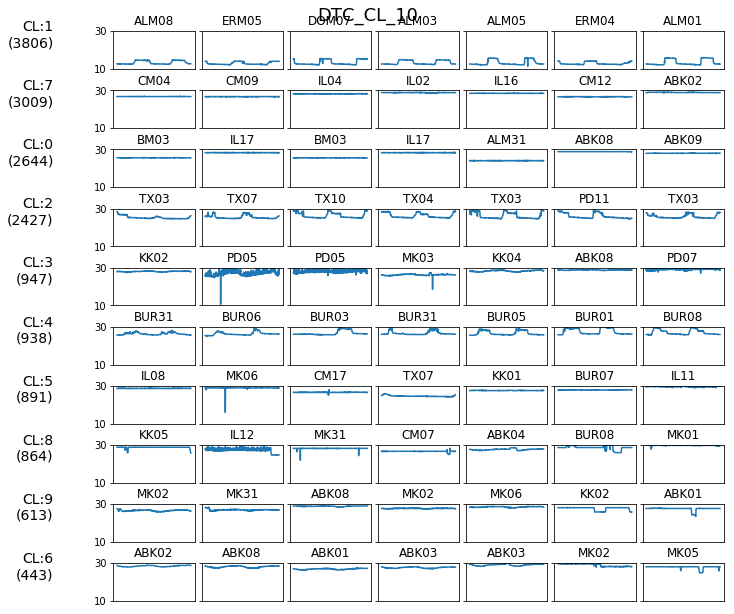

In [37]:
feature = 'DTC_CL_10'
df_pivot(Data_tst, feature)
plot_by_class(Data_tst, feature, my_lbl='site')
plt.savefig(f'{feature}.png', transparent=True)

### Compare Clusters to Classes (Power Type and Nominal Voltage):

In [38]:
feature = 'DTC_CL_10'

for meta_feat in ['NOM_VLT', 'PWR_TYPE']:
        get_feat_corr(Data_tst, feature, meta_feat, th=.8)

DTC_CL_10=1 & NOM_VLT=12V match with a v_measure of 0.935
no significant correlations found between DTC_CL_10 and PWR_TYPE


### Examine Fine-Grained Clusterings (k=200):

In [39]:
feature = 'DTC_CL'
k_lo = 200
k_hi = 200
score_df = pd.DataFrame(columns = [f'k={k}' for k in get_k_range(k_lo, k_hi)])
score_df.loc[feature], labels, idx = cluster_and_score(Embd_tst, get_k_range(k_lo, k_hi), 'kmeans')

for i, k in enumerate(get_k_range(k_lo, k_hi)):
    Data_tst[f'{feature}_{k}'] = labels[i]

Clustering data with k=200... score=0.328852844
The best k is 200 with a silhoette score of 0.33



DTC_CL_200:	COUNT
---------------------
2: 	02033
52: 	01017
107: 	00756
102: 	00407
84: 	00377
10: 	00344
187: 	00313
0: 	00279
71: 	00239
178: 	00228
21: 	00213
41: 	00211
121: 	00189
91: 	00188
63: 	00188
5: 	00184
17: 	00183
140: 	00174
117: 	00151
141: 	00147
172: 	00145
199: 	00141
143: 	00140
59: 	00137
192: 	00136
72: 	00136
118: 	00132
77: 	00132
54: 	00130
79: 	00126
60: 	00124
46: 	00119
30: 	00116
101: 	00113
66: 	00110
37: 	00104
197: 	00104
184: 	00102
70: 	00091
9: 	00091
68: 	00090
16: 	00088
165: 	00088
112: 	00083
4: 	00081
138: 	00080
87: 	00079
179: 	00079
49: 	00078
114: 	00078
74: 	00078
109: 	00076
1: 	00075
45: 	00075
111: 	00074
81: 	00073
64: 	00071
96: 	00069
155: 	00068
22: 	00068
193: 	00067
85: 	00066
113: 	00066
108: 	00066
173: 	00065
139: 	00064
137: 	00064
176: 	00061
61: 	00060
32: 	00059
51: 	00058
43: 	00058
163: 	00056
94: 	00055
169: 	00054
23: 	00053
171: 	00053
92: 	00053
73: 	00052
145: 	00051
116: 	00051
55: 	00050
33: 	00050
15: 	00050
97: 	

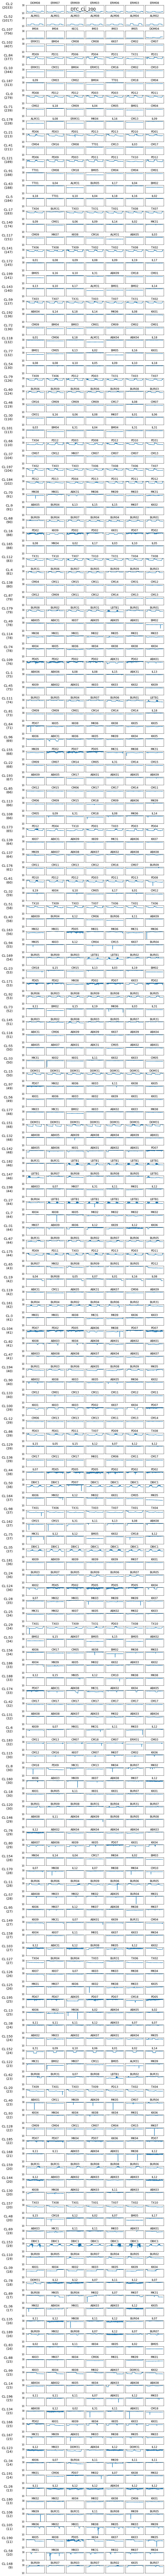

In [40]:
feature = 'DTC_CL_200'
df_pivot(Data_tst, feature)
plot_by_class(Data_tst, feature, my_lbl='site')
plt.savefig(f'{feature}.png', transparent=True)

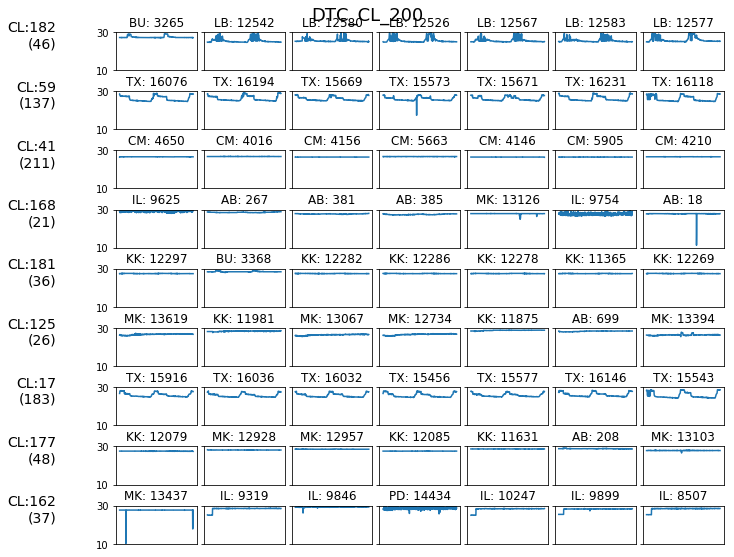

In [41]:
feature = 'DTC_CL_200'
plot_by_class(Data_tst, feature, my_lbl='index', cls=[182, 59, 41, 168, 181, 125, 17, 177, 162])
plt.savefig(f'{feature}.png', transparent=True)

## TEST WITH TEMPLATES

In [42]:
def NN_score(x, pos_ex, neg_ex):
    pos_dists = np.linalg.norm(x - pos_ex, axis=1)
    neg_dists = np.linalg.norm(x - neg_ex, axis=1)
    return neg_dists/(pos_dists+1e-15)

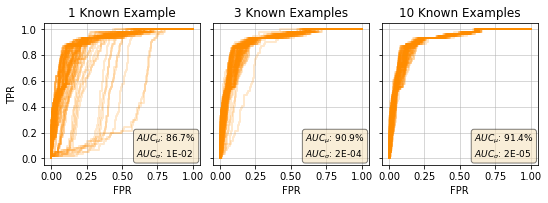

In [43]:
cat_event = Data_tst.copy()
cat_event = cat_event.loc[cat_event.Array == 'BU'].reset_index()
cat_event['Y'] = cat_event.PV_outage
data_embeds = cat_event[[c for c in cat_event.columns if c[0] == 'X']].values

samps_list = [1,3,10]
trials = 100

#fpr = np.zeros(trials)
#tpr = np.zeros(trials)
roc_auc = np.zeros((len(samps_list),trials))
fig, ax = plt.subplots(1,len(samps_list), figsize=(2.5*len(samps_list),3), sharey=True)

for j, samps in enumerate(samps_list):
    
    ax[j].set_title(f'{samps} Known Examples')
    if samps == 1:
        ax[j].set_title(f'{samps} Known Example')
        
    ax[j].set_xlabel('FPR')
    for i in range(trials):
        pos_idx = cat_event.loc[cat_event.Y == 1].sample(samps).rename_axis('idx').reset_index().idx.values
        neg_idx = cat_event.loc[cat_event.Y == 0].sample(samps*100).rename_axis('idx').reset_index().idx.values

        y_score = NN_score(data_embeds, data_embeds[pos_idx[:,]].mean(axis=0), data_embeds[neg_idx[:,]].mean(axis=0))
        y_true = cat_event.Y.values == 1

        fpr, tpr, th = roc_curve(y_true, y_score)
        roc_auc[j,i] = auc(fpr, tpr)

        ax[j].plot(fpr, tpr, color='darkorange', alpha=20/trials, lw=2)


    textstr = f'$AUC_\mu$: {np.mean(roc_auc[j]*100):0.1f}%\n$AUC_\sigma$: {np.var(roc_auc[j]):0.0E}'
    ax[j].text(0.6, 0.02, textstr, fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax[j].grid(linestyle='-', linewidth='0.5')
    
ax[0].set_ylabel('TPR')
#fig.suptitle('One-shot ROC curves', fontsize=18)
  
fig.tight_layout(pad=0.0, w_pad=0, h_pad=0)
fig.subplots_adjust(top=.80)

plt.show()

fig.savefig('oneshot_ROCs.png', transparent=True, dpi=300)

In [44]:
def NN_classifier(x, pos_ex, neg_ex):
    pos_dists = np.linalg.norm(x - pos_ex, axis=1)
    neg_dists = np.linalg.norm(x - neg_ex, axis=1)
    return neg_dists/pos_dists > 1.05

In [45]:
samps = 10
trials = 100

recall = np.zeros(trials)
precis = np.zeros(trials)

for i in range(trials):
    pos_idx = cat_event.loc[cat_event.Y == 1].sample(samps).rename_axis('idx').reset_index().idx.values
    neg_idx = cat_event.loc[cat_event.Y == 0].sample(samps*100).rename_axis('idx').reset_index().idx.values

    y_pred = NN_classifier(data_embeds, data_embeds[pos_idx[:,]].mean(axis=0), data_embeds[neg_idx[:,]].mean(axis=0))
    y_true = cat_event.Y.values == 1
    
    z = classification_report(y_true, y_pred,  output_dict=True)
    recall[i] = z['True']['recall']
    precis[i] = z['True']['precision']

print('recall:', np.mean(recall))
print('precis:', np.mean(precis))

print('recall_var:', np.var(recall))
print('precis_var:', np.var(precis))

cnf_matrix = confusion_matrix(y_true, y_pred)
#print(classification_report(y_true, y_pred))
print(cnf_matrix)

recall: 0.8570491803278688
precis: 0.26572014350337275
recall_var: 0.0018547702230583174
precis_var: 0.00031992238768180554
[[871 146]
 [  7  54]]


In [46]:
def score_to_pred(cat, alpha=None, print_stats=True, labels=['Y', 'Y_score', 'Y_pred'], output_stats=False):
    ytrue, yscore, ypred = labels

    cat = cat.copy(deep=True)
    fpr, tpr, th = roc_curve(cat[ytrue], cat[yscore])

    if alpha is None:
        idx = np.argmax(tpr * (1 - fpr))
        th = th[idx]
        alpha = fpr[idx]
    else:
        th = th[np.argmax(fpr > alpha)]

    cat[ypred] = False
    cat.loc[cat[yscore] > th, ypred] = True
    cat[ytrue] = cat[ytrue].astype('bool')

    z = classification_report(cat[ytrue], cat[ypred], output_dict=True)
    recall = z['True']['recall']
    precis = z['True']['precision']
    accury = (1 - len(cat.loc[cat[ytrue] ^ cat[ypred]]) / len(cat))

    cat['COND'] = ''

    cat.loc[cat[ytrue] > cat[ypred], 'COND'] = 'FN'
    cat.loc[cat[ytrue] < cat[ypred], 'COND'] = 'FP'
    cat.loc[cat[ytrue] & cat[ypred], 'COND'] = 'TP'
    cat.loc[~(cat[ytrue] | cat[ypred]), 'COND'] = 'TN'

    if print_stats:
        print('total pairs:         ', len(cat))
        print('type-I error rate:   ', alpha)
        print('-------------')
        # print('misclassified pairs: ', len(a.loc[a.Y ^ a.Y_PRED]))
        print('accuracy:            ',
              str(np.round(100 * accury, 1)) + '%')
        print('recall:              ', str(np.round(100 * recall, 1)) + '%')
        print('precision:           ', str(np.round(100 * precis, 1)) + '%')
        print('-------------')
        print(cat.COND.value_counts())
    if output_stats:
        return precis, recall, accury
    else:
        return cat

In [47]:
samps = 10
pos_idx = cat_event.loc[cat_event.Y == 1].sample(samps).rename_axis('idx').reset_index().idx.values
neg_idx = cat_event.loc[cat_event.Y == 0].sample(samps*100).rename_axis('idx').reset_index().idx.values
y_score = NN_score(data_embeds, data_embeds[pos_idx[:,]].mean(axis=0), data_embeds[neg_idx[:,]].mean(axis=0))
cat_event['Y_score'] = y_score

_ = score_to_pred(cat_event, .05)

total pairs:          1078
type-I error rate:    0.05
-------------
accuracy:             92.6%
recall:               50.8%
precision:            38.3%
-------------
TN    967
FP     50
TP     31
FN     30
Name: COND, dtype: int64
